In [2]:
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import polarTransform
from PIL import Image, ImageDraw
from tqdm import tqdm
import glob

In [3]:
# Get the paths of every file given a parent directory
def get_all_files(path):
    vect = []
    for path, subdirs, files in os.walk(path):
        for name in files:
            if (name == '.DS_Store') | (name=='Readme.txt'):
                pass
            else:
                vect.append(os.path.join(path, name))
        vect = sorted(vect)
    return vect

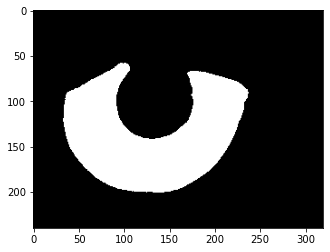

255
255


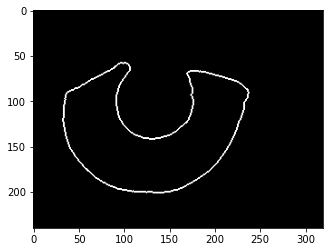

In [4]:
from skimage.segmentation import find_boundaries
from skimage.segmentation import find_boundaries
# Loading the image
images = get_all_files('/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/datasets_created/masks_DL/')
img = cv2.imread('/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/datasets_created/masks_DL/007/03_L.png', 0)
ret, thresh = cv2.threshold(img, 127, 255, 0)
bound = np.uint8(find_boundaries(thresh, mode='thick')*255.0)
plt.imshow(img, cmap='gray')
plt.show()
cimg = cv2.cvtColor(bound,cv2.COLOR_GRAY2BGR)
print(np.max(img))
plt.imshow(bound, cmap='gray')
print(np.max(bound))

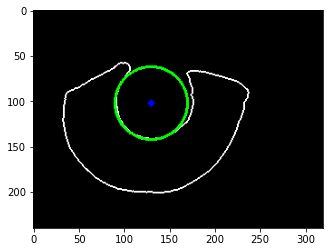

In [5]:
cimg = cv2.cvtColor(bound,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(bound, cv2.HOUGH_GRADIENT, 4, 20,
              param1=10,
              param2=100,
              minRadius=20,
              maxRadius=0)
circles = np.uint16(np.around(circles))
i = circles[0,:][0]
# draw the outer circle
cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
# draw the center of the circlea
cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
plt.imshow(cimg)

75.0
[190 134  36]


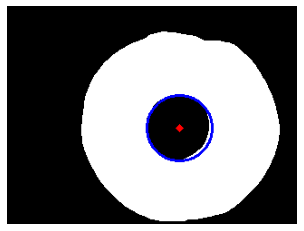

In [23]:
img = cv2.imread('/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/datasets_created/masks_DL/007/03_L.png', 0)
img = cv2.imread('/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/datasets_created/masks_DL/045/08_R.png', cv2.IMREAD_GRAYSCALE) 
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,4,20, param1=10,param2=100,minRadius=0,maxRadius=60)
circles = np.uint16(np.around(circles))
i = circles[0,:][0]
line = img[i[1],:]
deltaR = np.sum(line==255)/2
print(deltaR)
# draw the outer circle
cv2.circle(cimg,(i[0],i[1]),i[2],(0,0,255),2)
# draw the center of the circle
#cv2.line(cimg, (0,i[1]), (cimg.shape[1],i[1]), (0,0,255),2)
cv2.circle(cimg,(i[0],i[1]),2,(255,0,0),3)
plt.axis('off')
#cv2.circle(cimg,(i[0],i[1]),int(deltaR)+i[2],(0,0,255),2)
print(i)
plt.imshow(cimg)
plt.savefig('final1.png')

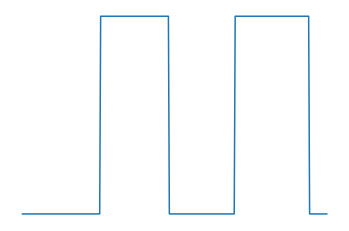

In [21]:
plt.axis('off')
plt.plot(line)
plt.savefig('final3.png')

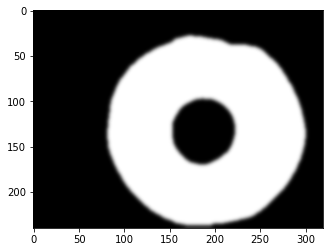

In [96]:
# Smooth with sigma > than eyelashes so that their value gets lower and so, their influence on the segmentation
smooth = cv2.GaussianBlur(img, (21,21), 2)
plt.imshow(smooth, cmap='gray')

[0, 255]
[0, 255]
[False, True]


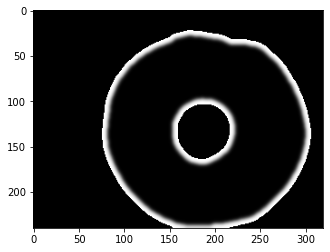

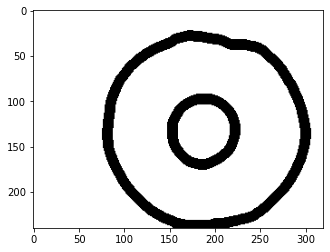

In [97]:
# Get "edges" and getting the sign image ot obtain a binary image
print([np.min(img), np.max(img)])
print([np.min(smooth), np.max(smooth)])
diff = (img - smooth) <= 0
print([np.min(diff), np.max(diff)])
plt.imshow((img-smooth), cmap='gray')
plt.show()
plt.imshow(diff, cmap = 'gray')
plt.show()

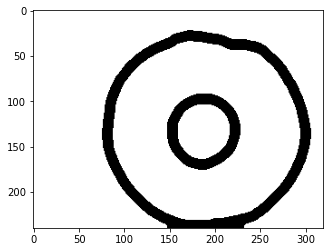

In [98]:
# Opening to remove small elements
op_size = 11
opening = cv2.morphologyEx(np.float32(diff), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(op_size,op_size)))
#opening = cv2.erode(np.float32(diff),cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(op_size,op_size)),iterations = 1)
#opening = cv2.dilate(opening, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(op_size+2,op_size+2)),iterations = 1)
plt.imshow(opening, cmap='gray')

In [99]:
# Get components 
ret,binary = cv2.threshold(np.uint8(opening),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, hierarchy= cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [100]:
# Get good contour in a 2 step process. 1st area criterion and 2nd getting the more circular one
candidate_contours = []
ecc_vect = []
circ_vect = []
for i, c in enumerate(contours):
    ar = cv2.contourArea(c)
    if ar > 100:
        (center,axes,orientation) = cv2.fitEllipse(c)
        majoraxis_length = max(axes)
        minoraxis_length = min(axes)
        ecc_vect.append(np.sqrt(1-(minoraxis_length/majoraxis_length)**2))
        circ_vect.append(4 * math.pi * ar / (cv2.arcLength(c, True) ** 2))
        candidate_contours.append(c)
#pupil_cont = candidate_contours[np.argmin(ecc_vect)]
pupil_cont = candidate_contours[np.argmax(circ_vect)]
cv2.drawContours(img, pupil_cont, -1, (255,0,0), 2);

103


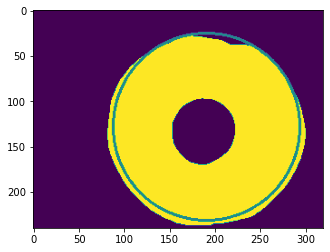

In [101]:
# Get coordinates of the bounding box of the pupil and get the center in a 2 step process
# to avoid wrong center estimation when the pupil es partially covered by the eyelid
x,y,w,h = cv2.boundingRect(pupil_cont)
r_pupil = int(w/2)
cx = int(x + w/2)
cy = (y+h) - r_pupil
#cv2.rectangle(img, (cx,cy), (cx,cy), (120,0,0), 10)
cv2.circle(img, (cx, cy), r_pupil, (120,120, 255), 2)
plt.imshow(img)
print(r_pupil)

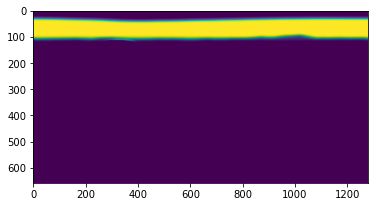

In [76]:
# Moving to polar C.S.
polar_thres, ptSettings = polarTransform.convertToPolarImage(smooth, center = (cx, cy),initialRadius=None, finalRadius=7*r_pupil, radiusSize=7*r_pupil)
polar_thres = (np.transpose(polar_thres))
plt.imshow(polar_thres)

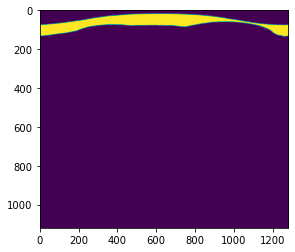

In [37]:
im = Image.fromarray(polar_thres)
plt.imshow(im)

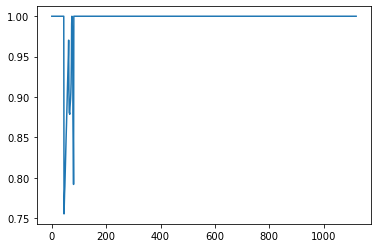

In [38]:
# Create a mask of the artificial 0s created by the polar system conversion
mask = ((polar_thres)!=0.0)

# Count how many 0s have been created row-wise 
notnan = np.sum(mask, axis=1)
unique = np.unique(notnan)
if len(unique==1):
    notnan = notnan/np.max(notnan)
else:
    notnan = (notnan-np.min(notnan))/(np.max(notnan)-np.min(notnan))
# If the newly added 0s are more than 25%, then treat them as if there were no 0s
notnan[notnan<0.75]=1.0

#notnan = (notnan-np.min(notnan))/(np.max(notnan)-np.min(notnan))

plt.plot((notnan))

#half = int(notnan.shape[0]/2)
#point = notnan[half:]<1.0
#find_limit = np.where(point==True)[0][0]+half

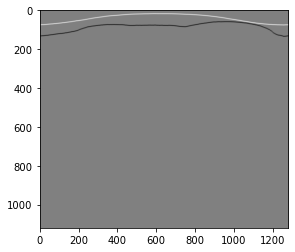

In [39]:
# compute the median of the single channel pixel intensities
sobely = cv2.Sobel(polar_thres,cv2.CV_32F,0,1,ksize=5)
plt.imshow(sobely, cmap='gray')



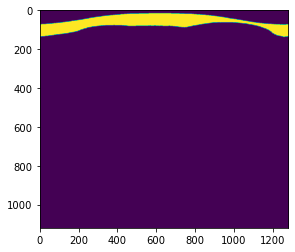

In [40]:
plt.imshow(mask)

[160, 208]


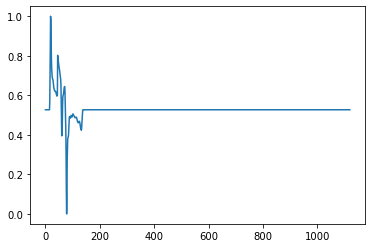

In [41]:
# Multiply the derivative image by the mask to prevent derivatives in the newly added region after polar conversion to affect the sum
sobely = sobely*mask

# Sum the derivative image row-wise
cum_sum = np.sum(sobely,axis=1)

# Normalize the sum by the "true" pixels
# This is the reason why, if the "false" pixels are more than 25%, ignore them
# If not, the maximum of this sum, will always be the rows with high content of "false" pixels
cum_sum = (cum_sum-np.min(cum_sum))/(np.max(cum_sum)-np.min(cum_sum))
cum_sum = cum_sum/notnan

plt.plot(cum_sum)

# Search for the second maximum assuming the outer boundary will not be at a radial distance less than 60% of the pupil radius
margin = int(0.3*r_pupil)
r_out_bound = np.argmin(cum_sum[r_pupil+margin:]) + r_pupil+margin
print([r_pupil, r_out_bound])

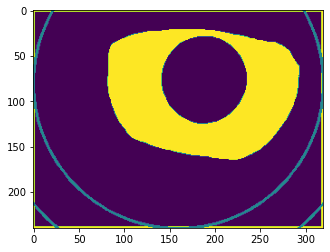

In [42]:
# Plot outer boundary
cv2.circle(img, (cx, cy), r_out_bound, (128,120, 0), 2)
plt.imshow(img)

In [5]:
from create_polar_im_DL_mask import create_polar_im_DL
# Saving the images
save_folder_masks = '/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/datasets_created/masks_DL_polar'
DL_masks = get_all_files('/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/datasets_created/masks_DL')
or_im = get_all_files('/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/dataset/images')

if not os.path.exists(save_folder_masks):
    os.mkdir(save_folder_masks)
    numb = ["{0:03}".format(i) for i in range(1,225)]
    for i in numb:
        os.mkdir(os.path.join(save_folder_masks,i))
            
for i in tqdm(range(len(images))):
    create_polar_im_DL(DL_masks[i],or_im[i],save_folder_masks)

100%|██████████| 2240/2240 [00:19<00:00, 116.64it/s]
